## Spooky Author Identification

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential,layers
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

### Read 'spooky.csv' dataset

In [2]:
df=pd.read_csv('spooky.csv')

In [3]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Drop 'id' column

In [4]:
df.drop(columns='id',inplace=True)

In [5]:
df

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
19574,"I could have fancied, while I looked at it, th...",EAP
19575,The lids clenched themselves together as if in...,EAP
19576,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,"For an item of news like this, it strikes us i...",EAP


### Check for missing values

In [6]:
df.isna().sum()

text      0
author    0
dtype: int64

### Check for duplicates

In [7]:
df.duplicated().sum()

0

### Print some of the text along with its author

In [8]:
for i in range(10):
    print(df['author'][i],'-----',df['text'][i])
    print()

EAP ----- This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.

HPL ----- It never once occurred to me that the fumbling might be a mere mistake.

EAP ----- In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.

MWS ----- How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.

HPL ----- Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.

MWS ----- A youth passed in solitude, my best years spent 

### Create a function to preproces the text

In [9]:
def preprocessing(sentence):
    text=re.sub(r'[^0-9A-Za-z]',' ',sentence).split()
    
    text=[i.lower() for i in text if i not in stopwords.words('english')]
    
    lemma=WordNetLemmatizer()
    texts=[lemma.lemmatize(i,'v') for i in text]
    
    return ' '.join(texts)

In [10]:
df['text']=df['text'].apply(preprocessing)

### Print some of the text after preprocess

In [11]:
for i in range(10):
    print(df['author'][i],'-----',df['text'][i])
    print()

EAP ----- this process however afford mean ascertain dimension dungeon i might make circuit return point whence i set without aware fact perfectly uniform seem wall

HPL ----- it never occur fumble might mere mistake

EAP ----- in leave hand gold snuff box caper hill cut manner fantastic step take snuff incessantly air greatest possible self satisfaction

MWS ----- how lovely spring as look windsor terrace sixteen fertile counties spread beneath speckle happy cottages wealthier towns look former years heart cheer fair

HPL ----- find nothing else even gold superintendent abandon attempt perplex look occasionally steal countenance sit think desk

MWS ----- a youth pass solitude best years spend gentle feminine fosterage refine groundwork character i cannot overcome intense distaste usual brutality exercise board ship i never believe necessary i hear mariner equally note kindliness heart respect obedience pay crew i felt peculiarly fortunate able secure service

EAP ----- the astronomer 

### Check for imbalance in the dataset

<AxesSubplot:xlabel='count', ylabel='author'>

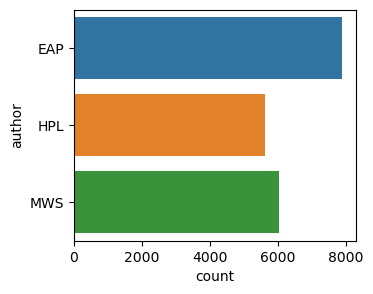

In [12]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.countplot(data=df,y='author')

### Split the dataset into Input & Target Variables

In [13]:
x=df['text']
y=df['author']

### Label Encode our target variables

In [14]:
encoder=LabelEncoder()

In [15]:
y=encoder.fit_transform(y)

In [16]:
encode=LabelBinarizer()

In [17]:
y=encode.fit_transform(y)

In [18]:
y

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

### Create Keras tokenizer object with 5000 max words
* Convert text to sequence
* Add padding

In [19]:
tokenizer=Tokenizer(num_words=5000)

In [20]:
tokenizer.fit_on_texts(x)

In [21]:
vocab_size=len(tokenizer.index_word)+1

In [22]:
def text_encoded(txt):
    encoded_text=tokenizer.texts_to_sequences(txt)
    
    pad=pad_sequences(encoded_text,maxlen=128)
    
    return pad

### Split the dataset into Training & Testing set

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [24]:
x_train=text_encoded(x_train)
x_test=text_encoded(x_test)

### Create keras Sequential model with GRU layers

In [25]:
model=Sequential([
    layers.Embedding(vocab_size,128),
    
    layers.GRU(128,return_sequences=True),
    layers.Dropout(0.2),
    layers.GRU(128),
    layers.Dropout(0.2),
    
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.2),
    
    layers.Dense(3,activation='softmax')
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2506368   
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

### Compile the model

In [27]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

### Train the model

In [28]:
model.fit(x_train,y_train,epochs=1,validation_split=0.05)

465/465 [==============================] - 193s 399ms/step - loss: 0.7060 - accuracy: 0.6902 - val_loss: 0.5567 - val_accuracy: 0.7704


### Make predictions with X_test

In [29]:
predicted=model.predict(x_test)

123/123 [==============================] - 14s 104ms/step


### Fetch the index of the higher probable prediction

In [31]:
predicted=[np.argmax(i) for i in predicted]

In [35]:
y_test=[np.argmax(i) for i in y_test]

### Evaluate the model

#### Accuracy score

In [36]:
accuracy_score(y_test,predicted)

0.789070480081716

#### Confusion matrix

<AxesSubplot:>

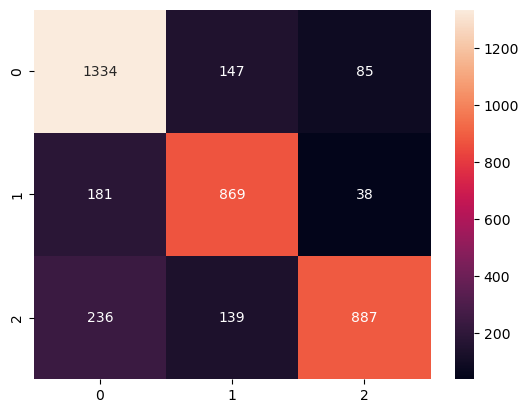

In [37]:
sns.heatmap(confusion_matrix(y_test,predicted),annot=True,fmt='d')

#### Classification Report

In [38]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1566
           1       0.75      0.80      0.77      1088
           2       0.88      0.70      0.78      1262

    accuracy                           0.79      3916
   macro avg       0.80      0.78      0.79      3916
weighted avg       0.80      0.79      0.79      3916



***